# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Мне нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичное-изучение-данных" data-toc-modified-id="Загрузка-и-первичное-изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичное изучение данных</a></span></li><li><span><a href="#Работа-с-пропущенными-значениями" data-toc-modified-id="Работа-с-пропущенными-значениями-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Работа с пропущенными значениями</a></span></li><li><span><a href="#Работа-с-выбросами" data-toc-modified-id="Работа-с-выбросами-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Работа с выбросами</a></span></li><li><span><a href="#Удаляем-лишние-столбцы" data-toc-modified-id="Удаляем-лишние-столбцы-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Удаляем лишние столбцы</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Обычная-модель" data-toc-modified-id="Обычная-модель-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обычная модель</a></span></li><li><span><a href="#Модели-с-бустингом" data-toc-modified-id="Модели-с-бустингом-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модели с бустингом</a></span><ul class="toc-item"><li><span><a href="#AdaBoost" data-toc-modified-id="AdaBoost-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>AdaBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка данных

Импортируем необходимые библиотеки.

In [112]:
import pandas as pd
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMRegressor

### Загрузка и первичное изучение данных

Загрузим данные и посмотрим на первые 5 строк.

In [47]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [48]:
df.shape

(354369, 16)

В нашем датасете 354369 наблюдений и 16 признаков.

Согласно документации, колонки означают следующее:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Видно, что можно удалить некоторые колонки, которые не должны оказывать влияния на цену автомобиля. Например, дата скачивания анкеты, почтовый индекс, дата последней активности и т.п.
Создадим новый список, в который внесем "ненужные" колонки. По мере обработки данных возможно добавим в него еще колонки.

In [49]:
columns_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode']

### Работа с пропущенными значениями

Сохраним датасет в новый и посмотрим на количество пропущенных значений в датасете.

In [50]:
clean_df = df.copy()
clean_df.isnull().sum().sort_values(ascending=False)

NotRepaired          71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Итак, больше всего пропущенных значений в колонке, которая говорит о том, ремонтировался ли автомобиль. Другие колонки с пропущенными значениями - тип автомобля, тип топлива, коробка передач и модель.

Предлагается заменить все пропущенные значения на 'unknown'.

In [51]:
clean_df.fillna('unknown', inplace=True)

### Работа с выбросами

Опишем значения методом `describe`.

In [52]:
clean_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**NumberOfPictures**

Видно, что в колонке `NumberOfPictures` все значения - нули. Поэтому добавим ее в наш список с колонками, которые можно удалить.

In [53]:
columns_to_drop.append('NumberOfPictures')

Не похоже, что в колонке с пробегом автомобиля `Kilometr` есть "выбросы". Минимальное значение - 5000 км, максимальное - 150000 км, что звучит вполне правдоподобно.

**Price**

Построим гистограмму значения распределения цены автомобиля.

<AxesSubplot:>

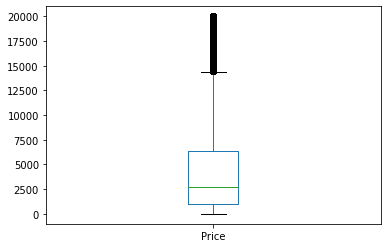

In [54]:
clean_df.Price.plot(kind='box')

Не похоже, чтобы в датасете было много выбросов сверху. Однако, есть "нулевые" цены, что невозможно (если только автомобиль не дают в дар в добрые руки). Посмотрим, сколько в датасете нулевых значений цены.

In [55]:
clean_df[clean_df.Price == 0].shape[0]

10772

Итак, в датасете ~10000 строк с нулевым значением цены. Напомню, в датасете порядка 350 тысяч наблюдений, поэтому предлагается удалить.

In [56]:
clean_df.Price.replace(0, float('nan'), inplace=True)
clean_df.dropna(inplace=True)

Опишем столбец с ценой еще раз.

In [57]:
clean_df.Price.describe()

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Видно, что остались еще очень маленькие значения цены. Ограничим датасет слева и справа так, чтобы использовать 99% данных. Для этого создадим переменные, которые обозначают верхний и нижний квантили.

In [58]:
high, low = 0.995, 0.005

Ограничим наш датасет согласно определенным квантилям.

In [59]:
clean_df = clean_df.query('@clean_df.Price.quantile(@low) < Price < @clean_df.Price.quantile(@high)')

Опишем столбец еще раз.

In [60]:
clean_df.Price.describe()

count    339559.000000
mean       4488.939592
std        4369.086046
min          55.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       19499.000000
Name: Price, dtype: float64

Маленькие значения все еще остались, но хотя бы они не равны 0 и 1.

**Power**

В данной колонке также присутствуют нулевые значения. Посчитаем их.

In [61]:
clean_df[clean_df.Power == 0].shape[0]

35294

Около 36 тысяч значений. Удалим их.

In [62]:
clean_df.Power.replace(0, float('nan'), inplace=True)
clean_df.dropna(inplace=True)

Теперь постром гистограмму ящик с усами.

<AxesSubplot:>

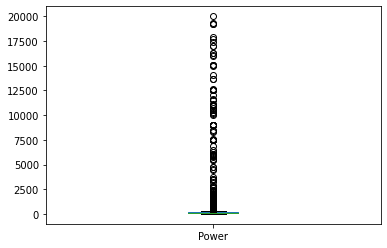

In [63]:
clean_df.Power.plot(kind='box')

Видно, что в датасете достаточно много "выбросов" с очень большой мощностью двигателя. От этих значений лучше бы избавиться.
Ограничим датасет слева и справа так, чтобы использовать 99% данных. Для этого создадим переменные, которые обозначают верхний и нижний квантили.

Ограничим наш датасет согласно определенным квантилям.

In [64]:
clean_df = clean_df.query('@clean_df.Power.quantile(@low) < Power < @clean_df.Power.quantile(@high)')

Посмотрим еще раз на ящик с усами.

<AxesSubplot:>

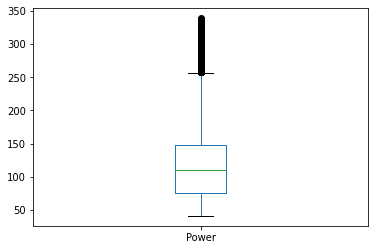

In [65]:
clean_df.Power.plot(kind='box')

Выглядит здорово, идем дальше.

**RegistrationYear**

Построим ящик с усами и посмотрим на распределения.

<AxesSubplot:>

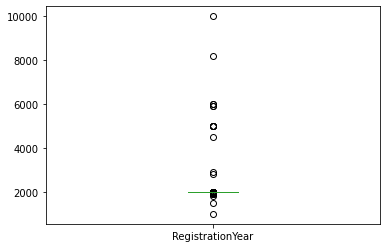

In [66]:
clean_df.RegistrationYear.plot(kind='box')

Видно, что есть выбросы как сверху, так и снизу. Но что это за параметр? Год регистрации автомобиля. Предположим, что это и есть год его производства.

Выкинем лишние значения так же, как и в случае с колонкой Power.

In [67]:
clean_df = clean_df.query('@clean_df.RegistrationYear.quantile(@low) < RegistrationYear < @clean_df.RegistrationYear.quantile(@high)')

Посмотрим еще раз на датасет.

<AxesSubplot:>

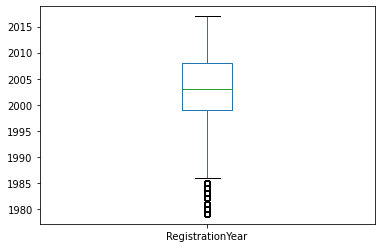

In [68]:
clean_df.RegistrationYear.plot(kind='box')

Видно, что есть "выбросы" снизу, но это не страшно, это лишь показывает, что в датасете есть старые машины. 

Опишем еще раз наш датасет методом `describe`.

In [69]:
clean_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,296672.000000,296672.000000,296672.000000,296672.000000,296672.000000,296672.0,296672.000000
mean,4696.259202,2003.375762,119.323131,129055.893377,5.980217,0.0,51180.001062
std,4409.827822,6.211639,50.130769,36082.530558,3.594602,0.0,25747.652771
min,55.000000,1979.000000,41.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30926.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50181.000000
75%,6850.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71711.000000
max,19499.000000,2017.000000,339.000000,150000.000000,12.000000,0.0,99998.000000


Видно, что от сильных "выбросов" мы избавились.

### Удаляем лишние столбцы

Удалим "лишние" столбцы в датасете и посмотрим на первые 5 строк.

In [70]:
clean_df.drop(columns=columns_to_drop, inplace=True)
clean_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300.0,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800.0,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500.0,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
5,650.0,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


Итак, в датасете остались только важные (по моему мнению) колонки. Можно переходить к построению моделей. 

**Вывод:**

На данном этапе была проведена первичная работа с данными, а именно:
- Данные были загружены, изучены признаки
- Пропущенные данные в категориальных признаках были заменены на 'unknown'
- Последовательно были выбраны 99% данных в столбцах Price, Power, RegistrationYear, чтобы избавиться от выбросов
- Были удалены столбцы, которые не должны оказывать влияния на предсказания.

## Обучение моделей

Разобьем наш датасет на признаки и целевую переменную. В качестве целевой переменной у нас выступает столбец `Price`.

In [71]:
X = clean_df.drop(columns='Price')
y = clean_df['Price']

### Обычная модель

Воспользуемся моделью `LinearRegression`. Но сначала необходимо перевести категориальные переменные в числовые. Проведем `OneHotEncoding`, воспользуясь функцией `get_dummies`.

In [72]:
object_columns = X.select_dtypes(include=['object']).columns
X_oh = pd.get_dummies(X, prefix=object_columns, drop_first=True)

Теперь разобьем датасет на тренировочную и тестовую выборки в соотношении 0.75:0.25 функцией `train_test_split`.

In [73]:
X_oh_train, X_oh_test, y_train, y_test = train_test_split(X_oh, y, test_size=0.25, random_state=42)

Построим модель, при этом посчитав, сколько секунд она тратит на обучение при помощи библиотеки `time`.

In [132]:
start = time.time()

lr = LinearRegression()
lr.fit(X_oh_train, y_train)

end = time.time()

Посчитаем, сколько обучалась модель.

In [134]:
time_fit_lr = end - start
print(f'Модель линейной регрессии обучилась за {time_fit_lr:.0f} секунд')

Модель линейной регрессии обучилась за 26 секунд


Посчитаем, как долго модель предсказывает значения.

In [135]:
start = time.time()

pred_lr = lr.predict(X_oh_train)

end = time.time()

In [136]:
time_pred_lr = end - start
print(f'Модель линейной регрессии предсказала значения за {time_pred_lr:.2f} секунд')

Модель линейной регрессии предсказала значения за 0.35 секунд


Теперь посчитаем RMSE метрику модели на тренировочной выборке.

In [78]:
rmse_lr = mean_squared_error(y_train, pred_lr) ** 0.5
print(f'RMSE линейной модели на тренировочной выборке составило {rmse_lr:.2f}')

RMSE линейной модели на тренировочной выборке составило 2337.23


Посчитаем RMSE на тестовой выборке.

In [79]:
pred_lr_test = lr.predict(X_oh_test)
rmse_lr_test = mean_squared_error(y_test, pred_lr_test) ** 0.5
print(f'RMSE линейной модели на тестовой выборке составило {rmse_lr_test:.2f}')

RMSE линейной модели на тестовой выборке составило 2329.37


Много ли это? Можно попробовать оценить, посчитав стандартное отклонение в тренировочном датасете.

In [83]:
y.describe()['std']

4409.827822041441

Видно, что отклонение предсказаний меньше, чем стандартное отклонение в датасете. Поэтому можно сказать, что наша модель линейной регрессии справилась с поставленной задачей.

Проверим другие модели.

### Модели с бустингом

#### AdaBoost

В данной модели используется бустинг, но не градиентный. Сразу используем `RandomizedSearchCV`, чтобы подобрать оптимальные параметры. Переберем по три значения данных параметров, но построим всего только 3 разных модели.

In [98]:
params = {'n_estimators':list(range(25, 76, 25)),
          'learning_rate':[0.1, 0.5, 1],
          'loss':['linear', 'square', 'exponential']}

adaregr = AdaBoostRegressor(random_state=42)

rs = RandomizedSearchCV(adaregr, param_distributions=params, n_iter=3, cv=3, n_jobs=-1)

Проведем процесс подбора параметров.

In [99]:
rs.fit(X_oh_train, y_train)

RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(random_state=42), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [25, 50, 75]})

Сохраним и обучим модель с лучшими параметрами.

In [142]:
ar = rs.best_estimator_

start = time.time()

ar.fit(X_oh_train, y_train)

end = time.time()

Посчитаем, сколько обучалась модель.

In [145]:
time_fit_ar = end - start
print(f'Модель AdaBoost обучилась за {time_fit_ar:.0f} секунд')

Модель AdaBoost обучилась за 171 секунд


Посчитаем, как долго модель предсказывает значения.

In [146]:
start = time.time()

pred_ar = ar.predict(X_oh_train)

end = time.time()

In [147]:
time_pred_ar = end - start
print(f'Модель AdaBoost предсказала значения за {time_pred_ar:.2f} секунд')

Модель AdaBoost предсказала значения за 6.70 секунд


Теперь посчитаем RMSE метрику модели на тренировочной выборке.

In [148]:
rmse_ar = mean_squared_error(y_train, pred_ar) ** 0.5
print(f'RMSE модели AdaBoost на тренировочной выборке составило {rmse_ar:.2f}')

RMSE модели AdaBoost на тренировочной выборке составило 2578.65


Посчитаем RMSE на тестовой выборке.

In [110]:
pred_ar_test = ar.predict(X_oh_test)
rmse_ar_test = mean_squared_error(y_test, pred_ar_test) ** 0.5
print(f'RMSE модели AdaBoost на тестовой выборке составило {rmse_ar_test:.2f}')

RMSE модели AdaBoost на тестовой выборке составило 2568.83


Напомню, что стандартное отклонение цены составляет 4410. Можно сказать, что наша модель справилась с предсказаниями, но сделала это хуже и дольше модели линейной регресиси.

Попробуем последнюю модель.

#### LightGBM

Данная модель использует градиентный бустинг. Также используем `RandomizedSearchCV`, чтобы подобрать параметры модели.

В данной модели не нужно кодировать категориальные переменные, достаточно просто перевести их в категориальный тип.

In [115]:
for col in X.select_dtypes(include=['object']):
    X[col] = X[col].astype('category')

Теперь разобьем датасет на тренировочный и тестовый.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [119]:
params = {'n_estimators':list(range(50, 101, 25)),
          'learning_rate':[0.1, 0.5, 1],
          'max_depth':list(range(1, 11, 2))}

lgbm = LGBMRegressor(random_state=42)

rs_lgbm = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=3, cv=3, n_jobs=-1)

Проведем процесс подбора параметров.

In [120]:
rs_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [50, 75, 100]})

Сохраним и обучим модель с лучшими параметрами.

In [149]:
lg = rs_lgbm.best_estimator_

start = time.time()

lg.fit(X_train, y_train)

end = time.time()

Посчитаем, сколько обучалась модель.

In [150]:
time_fit_lg = end - start
print(f'Модель LightGBM обучилась за {time_fit_lg:.0f} секунд')

Модель LightGBM обучилась за 64 секунд


Посчитаем, как долго модель предсказывает значения.

In [151]:
start = time.time()

pred_lg = lg.predict(X_train)

end = time.time()

In [152]:
time_pred_lg = end - start
print(f'Модель LightGBM предсказала значения за {time_pred_lg:.2f} секунд')

Модель LightGBM предсказала значения за 1.52 секунд


Теперь посчитаем RMSE метрику модели на тренировочной выборке.

In [153]:
rmse_lg = mean_squared_error(y_train, pred_lg) ** 0.5
print(f'RMSE модели LightGBM на тренировочной выборке составило {rmse_lg:.2f}')

RMSE модели LightGBM на тренировочной выборке составило 1431.63


Посчитаем RMSE на тестовой выборке.

In [154]:
pred_lg_test = lg.predict(X_test)
rmse_lg_test = mean_squared_error(y_test, pred_lg_test) ** 0.5
print(f'RMSE модели LightGBM на тестовой выборке составило {rmse_lg_test:.2f}')

RMSE модели LightGBM на тестовой выборке составило 1516.17


Итак, данная модель обучилась за 5 секунд и показала RMSE в 1516, что меньше чем у других двух моделей.

**Вывод:**

На данном этапе были построены три модели, LinearRegression, AdaBoost и LightGBM. Для каждой модели были определены:
- Время обучения
- Время предсказания
- RMSE на тренировочных данных
- RMSE на тестовых данных

На следующем этапе данные значения будут проанализированы для всех моделей.

## Анализ моделей

Создадим датасет, в котором запишем все параметры, описывающие работу моделей, полученные на предыдущем этапе.

In [162]:
data = pd.DataFrame({'Fitting time': [time_fit_lr, time_fit_ar, time_fit_lg],
                     'Prediction time': [time_pred_lr, time_pred_ar, time_pred_lg],
                     'Train RMSE':[rmse_lr, rmse_ar, rmse_lg],
                     'Test RMSE':[rmse_lr_test, rmse_ar_test, rmse_lg_test]}, 
                     index=['Linear Regression', 'AdaBoost', 'LightGBM'])

Напечатаем полученный датасет.

In [163]:
data

,Fitting time,Prediction time,Train RMSE,Test RMSE
Linear Regression,26.074998,0.348500,2337.230773,2329.368495
AdaBoost,171.474275,6.696061,2578.646036,2568.826883
LightGBM,63.602351,1.517550,1431.627526,1516.171745


Итак, видно, что:
- Самой быстрой моделью по обучению и предсказанию является модель LinearRegression.
- Самой долгой моделью по обучению и предсказанию являетяс модель AdaBoost.
- Модели LinearRegression и AdaBoost обладают сопоставимыми RMSE на тренировочных и тестовых выборках: 2300 и 2500, соответственно.
- Модель LightGBM обучается быстрее модели AdaBoost, но медленнее LinearRegression. Однако, она дает наименьшее значение RMSE для тренировочной и тестовой выборок: 1400 и 1500, соответственно.

## Общий вывод 

В данной работе была построена модель, которая предсказвыает цену автомобиля исходя из имеющихся данных о прошлых объявлениях:
- Сначала была проведена предобработка данных.
- Были построены три модели, LinearRegression, AdaBoost и LightGBM.
- Модель LightGBM оказалась самой оптимальной с точки зрения времени выполнения/полученного RMSE.